<a href="https://colab.research.google.com/github/anmaxwell/UniNotebooks/blob/master/workissues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install "git+https://github.com/facebookresearch/fastText.git"

  Cloning https://github.com/facebookresearch/fastText.git to /tmp/pip-req-build-b4r7or35
  Running command git clone -q https://github.com/facebookresearch/fastText.git /tmp/pip-req-build-b4r7or35
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2876002 sha256=3587d533f31037ffd156d39fe0066a8efca666b8ae99c285c7c72cb57fffd22d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ernp2kw0/wheels/69/f8/19/7f0ab407c078795bc9f86e1f6381349254f86fd7d229902355
Successfully built fasttext


Install all necessary packages

In [3]:
import fasttext.util
import numpy as np
import pandas as pd
import re

from keras import layers
from keras.layers import Dropout 
from keras.models import Sequential
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Read in data and look at first item

In [4]:
df = pd.read_csv('ModelData.csv', names=['text','issue'], sep=',')
print(df.iloc[0])

text     install sent otdl
issue                    0
Name: 0, dtype: object


Create labels

In [0]:
labels = df['issue'].values

Load the fasttext model

In [6]:
fasttext.util.download_model('en', if_exists='ignore') 
ft = fasttext.load_model('cc.en.300.bin')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Set the parameters

In [0]:
review_length = 50
data_count = len(df)
dims = ft.get_dimension()

Function to take the text from the review column, clean it, turn it to individual words then convert to vectors

In [0]:
def text_to_vector(text):

  text = text.replace('&', ' and ')
  text = text.replace('@', ' at ')
  text = re.sub(r'[^\x41-\x7f]',r' ',text)
  text = text.lower().split()

  window = text[-review_length:]
  
  vectors = np.zeros((review_length, dims))

  for i, word in enumerate(window):
      vectors[i, :] = ft.get_word_vector(word).astype('float32')

  return vectors


Function to create the word embedding

In [0]:
def create_word_embedding(df):

    word_embedding = np.zeros((len(df), review_length, dims), dtype='float32')

    for i, review in enumerate(df['text'].values):
        word_embedding[i, :] = text_to_vector(review)

    return word_embedding

Create the embedding

In [0]:
embedding = create_word_embedding(df)

Create the training and test set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(embedding, labels, test_size=0.20, random_state=42)

Create the CNN

In [0]:
def cnn_text_classifier():

    model = Sequential()
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(review_length, dims)))
    #model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.GlobalAveragePooling1D())
    model.add(Dropout(0.5))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

Build the model

In [32]:
model = cnn_text_classifier()
history = model.fit(X_train, y_train, epochs=20, verbose=False, validation_data=(X_test, y_test), batch_size=10)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 48, 128)           115328    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 116,629
Trainable params: 116,629
Non-trainable params: 0
_________________________________________________________________


Check the accuracy

In [34]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9262
Testing Accuracy:  0.8825


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(training):
    acc = training.history['accuracy']
    val_acc = training.history['val_accuracy']
    loss = training.history['loss']
    val_loss = training.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 2)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'y', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


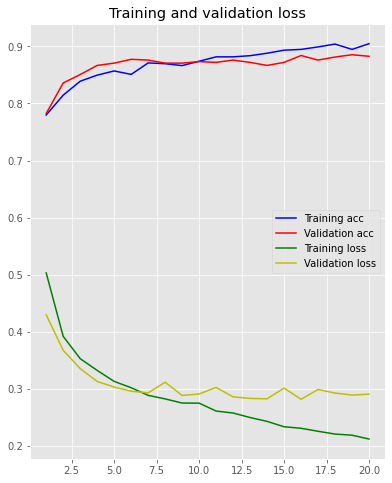

In [36]:
plot_history(history)

In [0]:
def model_predict(comment):
  comment_vector = create_word_embedding(comment)
  issue_value = model.predict(comment_vector)
  print(issue_value)
  for i,item in enumerate(issue_value):
    if item >0.5:
      print(i,"Issue")
    else:
      print(i,"No Issue")

In [84]:
to_predict = pd.read_csv('predict.csv', names=['text'])
print(df.iloc[0])

text     install sent otdl
issue                    0
Name: 0, dtype: object


In [85]:
model_predict(to_predict)

[[0.8939246 ]
 [0.80271614]
 [0.87259614]
 [0.00164273]
 [0.04491639]
 [0.05616602]
 [0.48245683]
 [0.84530133]
 [0.00145283]
 [0.14357832]
 [0.9353223 ]
 [0.9353223 ]
 [0.93429685]
 [0.9024372 ]
 [0.02060059]
 [0.3554108 ]
 [0.71222574]]
0 Issue
1 Issue
2 Issue
3 No Issue
4 No Issue
5 No Issue
6 No Issue
7 Issue
8 No Issue
9 No Issue
10 Issue
11 Issue
12 Issue
13 Issue
14 No Issue
15 No Issue
16 Issue
